In [29]:
import pandas as pd
import os
from glob import glob
import scipy
from sklearn.preprocessing import quantile_transform
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns
import numpy as np

In [30]:
############################################
## TCGA files
tcga_dir = "/Users/michael/cheng-project/tcga-data/tcga-gbm-rnaseq/rnaseq"
tcga_files = glob(os.path.join(tcga_dir, "*.tsv"))

tcga_dfs = []

for file in tcga_files:
    sample_name = os.path.splitext(os.path.basename(file))[0] + "_tcga"
    
    df = pd.read_csv(file, sep="\t", usecols=["gene_id", "tpm_unstranded"])
    df.rename(columns={"tpm_unstranded": sample_name}, inplace=True)
    df.set_index("gene_id", inplace=True)
    tcga_dfs.append(df)

tcga_gbm_df = pd.concat(tcga_dfs, axis=1)

In [31]:
# Load tumor RNA-seq file (2-column file: gene_id, tumor_rnaseq)
teresa_df = pd.read_csv("/Users/michael/cheng-project/boston-gene/rnaseq/core-rnaseq/star_rsem_gencode-v36/rsem.merged.gene_tpm.cleaned.tsv", sep="\t",
                        names=["gene_id", "teresa_gbm"], header=0).set_index("gene_id")

In [32]:
# combine tcga with teresa
combined_with_teresa = pd.concat([tcga_gbm_df,teresa_df], axis=1)
combined_with_teresa_log2 = combined_with_teresa.map(lambda x: np.log2(x + 1))

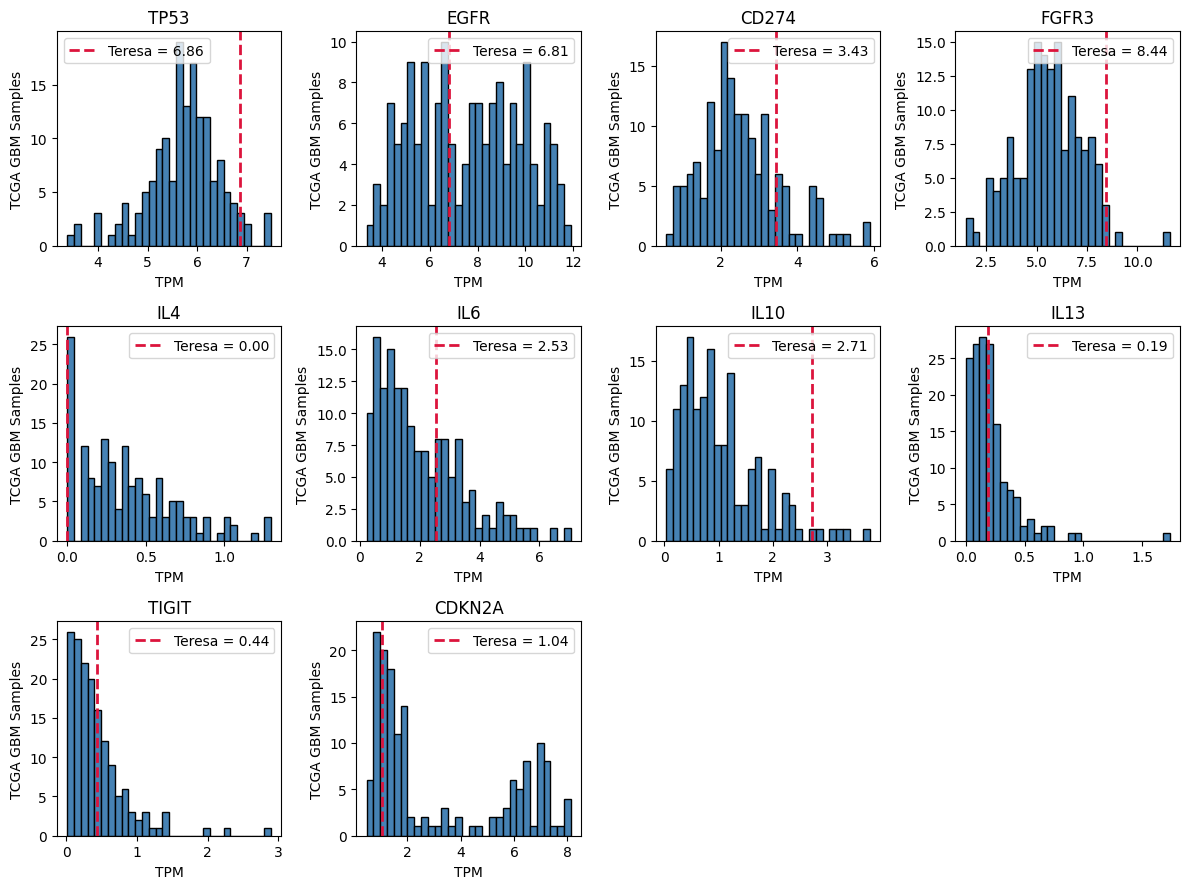

In [34]:
# ────────────────────────────────────────────────────────────────
# 1.  Load ENSG ↔ symbol map (no GTF parsing needed)
# ────────────────────────────────────────────────────────────────
def load_symbol_map(map_file="/Users/michael/cheng-project/boston-gene/rnaseq/core-rnaseq/star_rsem_gencode-v36/gencode.v36.geneid.genename.map.txt"):
    """
    Returns two dicts:
        sym2ensg : UPPER-case symbol  → ENSG (with version)
        ensg2sym : ENSG (with version) → original symbol
    """
    df_map = pd.read_csv(map_file, sep="\t", header=None,
                         names=["ensg", "symbol"], dtype=str)
    sym2ensg = {s.upper(): e for e, s in df_map.values}
    ensg2sym = {e: s for e, s in df_map.values}
    return sym2ensg, ensg2sym

sym2ensg, ensg2sym = load_symbol_map()

# ────────────────────────────────────────────────────────────────
# 2.  Histogram helper – input symbols, look up ENSG for DataFrame,
#     but keep symbol as plot title
# ────────────────────────────────────────────────────────────────
def plot_histograms_from_symbols(df: pd.DataFrame,
                                 symbols,
                                 teresa_col: str = "teresa_gbm"):
    """
    df       : genes × samples TPM matrix (index = ENSG **with version**)
    symbols  : list of 1–16 HGNC symbols (case-insensitive)
    """
    ensg_list, title_list, missing = [], [], []

    for sym in symbols:
        key = sym.upper()
        if key in sym2ensg:
            ensg = sym2ensg[key]
            if ensg in df.index:
                ensg_list.append(ensg)
                title_list.append(sym)           # keep original case
            else:
                missing.append(f"{sym} (no TPM row)")
        else:
            missing.append(f"{sym} (no mapping)")

    if missing:
        raise ValueError("Not found: " + ", ".join(missing))

    # ── plotting grid size ─────────────────────────────────────────
    n, ncols = len(ensg_list), 4
    nrows    = max(1, math.ceil(n / ncols))
    figsize  = (8, 6) if n == 1 else (ncols * 3, nrows * 3)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)

    cohort = df.drop(columns=[teresa_col])
    teresa = df[teresa_col]

    # ── make each histogram ───────────────────────────────────────
    for i, (ensg, sym) in enumerate(zip(ensg_list, title_list)):
        r, c = divmod(i, ncols)
        ax   = axes[r, c]

        vals = cohort.loc[ensg].values
        tval = teresa.loc[ensg]

        ax.hist(vals, bins=30, color="steelblue", edgecolor="black")
        ax.axvline(tval, color="crimson", ls="--", lw=2,
                   label=f"Teresa = {tval:.2f}")
        ax.set_title(sym)                   # show gene symbol
        ax.set_xlabel("TPM")
        ax.set_ylabel("TCGA GBM Samples")
        ax.legend()

    # hide unused subplots
    for j in range(n, nrows * ncols):
        r, c = divmod(j, ncols)
        axes[r, c].axis("off")

    plt.tight_layout()
    plt.show()

# ────────────────────────────────────────────────────────────────
# 3.  Example usage
# ────────────────────────────────────────────────────────────────
genes_of_interest = ["TP53", "EGFR", "CD274", "FGFR3", "IL4","IL6","IL10","IL13","TIGIT","CDKN2A"]
plot_histograms_from_symbols(combined_with_teresa_log2, genes_of_interest)

#### add percentile right onto the plot
